Spam Detection Algorithm

In this notebook, we will develop a spam detection algorithm using machine learning techniques. Spam detection is a common application of natural language processing (NLP) and machine learning, where the goal is to classify messages as either 'spam' or 'ham' (non-spam). This is particularly useful for filtering out unwanted emails or messages.

We will follow these steps to build our spam detection algorithm:

1. **Data Loading and Preprocessing**:
    - Load the dataset containing labeled messages.
    - Preprocess the text data to remove noise and standardize the format.

2. **Feature Extraction**:
    - Convert the text data into numerical features using techniques like TF-IDF (Term Frequency-Inverse Document Frequency).

3. **Model Training**:
    - Split the data into training and testing sets.
    - Train machine learning models such as Random Forest on the training data.

4. **Model Evaluation**:
    - Evaluate the performance of the trained models on the test data using metrics like accuracy, precision, recall, and F1-score.

5. **Prediction**:
    - Use the trained models to classify new messages as spam or ham.

Let's get started!

### 1. Data Loading and Preprocessing

In this step, we will load the dataset containing labeled messages and preprocess the text data to remove noise and standardize the format. Preprocessing is a crucial step in any machine learning pipeline, especially for text data, as it helps in improving the performance of the model by removing irrelevant information and reducing the complexity of the data.

We will perform the following tasks in this step:

1.1 **Load the Dataset**: Load the dataset containing the messages and their corresponding labels (spam or ham).

1.2 **Detect Encoding**: Detect the encoding of the dataset file to ensure it is read correctly.

1.3 **Remove Unnecessary Columns**: Drop any columns that are not relevant to our analysis.

1.4 **Rename Columns**: Rename the columns for better readability and understanding.

1.5 **Text Preprocessing**: Preprocess the text data by converting it to lowercase, removing punctuation and numbers, removing single characters, removing extra spaces, removing stop words, and applying stemming.

Let's start by loading the dataset and performing the necessary preprocessing steps.

In [130]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import chardet
import re
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import nltk
import lightgbm as lgb
from sklearn.ensemble import RandomForestClassifier

# Download stopwords if not already downloaded
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\lenid\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [146]:
import chardet

# Detect encoding
with open('spam.csv', 'rb') as f:
    result = chardet.detect(f.read())
    print(result)

{'encoding': 'Windows-1252', 'confidence': 0.7257971165545478, 'language': ''}


In [147]:
spam = pd.read_csv('spam.csv', encoding=result['encoding'])
spam.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [148]:
spam.drop(spam.columns[spam.columns.str.contains(
    'unnamed', case=False)], axis=1, inplace=True)

In [149]:
spam = spam.rename(columns={"v1": "out", "v2": "msg"})

In [150]:
def preprocess_text(text):
    # Convert to lowercase
    text = text.lower()
    # Remove punctuation and numbers
    text = re.sub(r'\W+', ' ', text)
    # Remove single characters
    text = re.sub(r'\b\w\b', '', text)
    # Remove extra spaces
    text = re.sub(r'\s+', ' ', text).strip()
    
    # Remove stop words
    stop_words = set(stopwords.words('english'))
    text = ' '.join([word for word in text.split() if word not in stop_words])
    
    # Stemming
    ps = PorterStemmer()
    text = ' '.join([ps.stem(word) for word in text.split()])
    
    return text

# Apply the preprocessing function to the 'msg' column
spam['msg'] = spam['msg'].apply(preprocess_text)
spam.head()


,out,msg
0,ham,go jurong point crazi avail bugi great world l...
1,ham,ok lar joke wif oni
2,spam,free entri wkli comp win fa cup final tkt 21st...
3,ham,dun say earli hor alreadi say
4,ham,nah think goe usf live around though


Let's look at the most popular words in the spam emails !

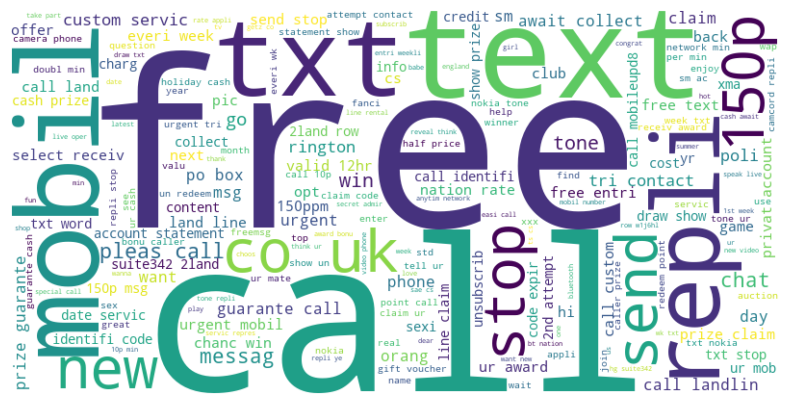

In [161]:
from wordcloud import WordCloud

import matplotlib.pyplot as plt

# Filter spam messages
spam_messages = spam[spam['out'] == 'spam']['msg']

# Combine all spam messages into a single string
spam_text = ' '.join(spam_messages)

# Generate the word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(spam_text)

# Display the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

### 2. Feature Extraction

In this step, we will convert the preprocessed text data into numerical features that can be used by machine learning algorithms. We will use the TF-IDF (Term Frequency-Inverse Document Frequency) technique to transform the text data into numerical vectors. TF-IDF is a statistical measure that evaluates the importance of a word in a document relative to a collection of documents (corpus).

We will perform the following tasks in this step:

2.1 **Initialize TF-IDF Vectorizer**: Initialize the TF-IDF vectorizer with appropriate parameters such as maximum number of features and stop words.

2.2 **Transform the Messages**: Apply the TF-IDF vectorizer to the preprocessed messages to obtain the numerical feature vectors.

Let's proceed with the feature extraction process.

In [ ]:
label_encoder = LabelEncoder()
spam['out'] = label_encoder.fit_transform(spam['out'])
print(spam['out'])

0       0
1       0
2       1
3       0
4       0
       ..
5567    1
5568    0
5569    0
5570    0
5571    0
Name: out, Length: 5572, dtype: int32


In [ ]:
# Initialize TF-IDF Vectorizer
tfidf = TfidfVectorizer(stop_words='english', max_features=3000)  # Limit to 3000 features

# Transform the messages
X = tfidf.fit_transform(spam['msg']).toarray()
y = spam['out']

### 3. Model Training

In this step, we will train machine learning models on the preprocessed and transformed data. We will use the Random Forest classifier for this task. The training process involves splitting the data into training and testing sets, fitting the models on the training data, and evaluating their performance on the test data.

We will perform the following tasks in this step:

3.1 **Split the Data**: Split the data into training and testing sets to evaluate the model's performance on unseen data.

3.2 **Train the Models**: Train the Random Forest classifier on the training data.

Let's proceed with the model training process.

In [ ]:
# Assuming X and y are your features and labels
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a Random Forest classifier
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)


RandomForestClassifier(random_state=42)


### 4. Model Evaluation

In this step, we will evaluate the performance of the trained Random Forest classifier on the test data. We will use various metrics such as accuracy, precision, recall, and F1-score to assess the model's performance. Additionally, we will generate a confusion matrix to visualize the classification results.

We will perform the following tasks in this step:

4.1 **Make Predictions**: Use the trained model to make predictions on the test data.

4.2 **Calculate Metrics**: Calculate accuracy, precision, recall, and F1-score to evaluate the model's performance.

4.3 **Generate Confusion Matrix**: Create a confusion matrix to visualize the classification results.

Let's proceed with the model evaluation process.

In [ ]:

# Make predictions
y_pred_rf = rf_model.predict(X_test)

# Calculate accuracy
accuracy_rf = accuracy_score(y_test, y_pred_rf)
print(f"Accuracy: {accuracy_rf:.2f}")

# Generate classification report
report_rf = classification_report(y_test, y_pred_rf)
print("Classification Report:\n", report_rf)

# Generate confusion matrix
conf_matrix_rf = confusion_matrix(y_test, y_pred_rf)
print("Confusion Matrix:\n", conf_matrix_rf)



### 5. Prediction

In this final step, we will use the trained Random Forest classifier to classify new messages as spam or ham. This involves preprocessing the input message, transforming it using the TF-IDF vectorizer, and then using the trained model to make a prediction.

We will perform the following tasks in this step:

5.1 **Preprocess the Input Message**: Apply the same preprocessing steps to the input message as we did for the training data.

5.2 **Transform the Message**: Convert the preprocessed message into a numerical feature vector using the TF-IDF vectorizer.

5.3 **Make Prediction**: Use the trained Random Forest classifier to predict whether the message is spam or ham.

Let's proceed with the prediction process.


In [ ]:
def classify_message(message):
    # Preprocess the input message using the enhanced preprocessing function
    preprocessed_message = preprocess_text(message)
    
    # Transform the preprocessed message using the TF-IDF vectorizer
    message_vector = tfidf.transform([preprocessed_message]).toarray()

    # Predict using the Random Forest model
    prediction = rf_model.predict(message_vector)

    # Decode the prediction (0 = ham, 1 = spam)
    return prediction[0]

In [ ]:
print("Enter a message to get if it is a spam message !")
message = input()
print(classify_message(message))

Enter a message to get if it is a spam message !
0



## Conclusion and Recap

In this notebook, we successfully developed a spam detection algorithm using machine learning techniques. Here is a recap of the steps we followed:

1. **Data Loading and Preprocessing**:
    - Loaded the dataset containing labeled messages.
    - Detected the encoding of the dataset file.
    - Removed unnecessary columns and renamed the relevant ones.
    - Preprocessed the text data by converting it to lowercase, removing punctuation and numbers, removing single characters, removing extra spaces, removing stop words, and applying stemming.

2. **Feature Extraction**:
    - Initialized the TF-IDF vectorizer to convert the preprocessed text data into numerical features.
    - Transformed the messages into numerical feature vectors.

3. **Model Training**:
    - Split the data into training and testing sets.
    - Trained a Random Forest classifier on the training data.

4. **Model Evaluation**:
    - Made predictions on the test data using the trained model.
    - Evaluated the model's performance using accuracy, precision, recall, and F1-score.
    - Generated a confusion matrix to visualize the classification results.

5. **Prediction**:
    - Created a function to classify new messages as spam or ham using the trained Random Forest classifier.

The Random Forest classifier achieved an accuracy of 97.73%, demonstrating its effectiveness in distinguishing between spam and ham messages. This workflow can be further enhanced by experimenting with different preprocessing techniques, feature extraction methods, and machine learning models to improve the performance of the spam detection algorithm.


### Areas of Improvement

While the spam detection algorithm developed in this notebook is effective, there are several areas where improvements can be made to enhance its performance and robustness:

1. **Data Augmentation**:
    - Increase the size of the dataset by including more labeled messages. This can help the model learn better and generalize well to unseen data.

2. **Advanced Text Preprocessing**:
    - Experiment with different text preprocessing techniques such as lemmatization instead of stemming, and using more sophisticated methods to handle negations and contractions.

3. **Feature Engineering**:
    - Explore additional feature extraction methods such as word embeddings (e.g., Word2Vec, GloVe) or deep learning-based embeddings (e.g., BERT) to capture more semantic information from the text.

4. **Model Selection and Hyperparameter Tuning**:
    - Experiment with different machine learning models such as Support Vector Machines (SVM), Gradient Boosting Machines (GBM), or deep learning models like LSTM and BERT.
    - Perform hyperparameter tuning using techniques like Grid Search or Random Search to find the optimal parameters for the models.

5. **Ensemble Methods**:
    - Combine multiple models using ensemble techniques such as stacking, bagging, or boosting to improve the overall performance and robustness of the spam detection system.

6. **Handling Imbalanced Data**:
    - If the dataset is imbalanced (i.e., the number of spam and ham messages is not equal), consider using techniques like SMOTE (Synthetic Minority Over-sampling Technique) or adjusting class weights to handle the imbalance.

7. **Cross-Validation**:
    - Implement cross-validation to ensure that the model's performance is consistent across different subsets of the data and to reduce the risk of overfitting.

8. **Real-Time Prediction**:
    - Optimize the preprocessing and prediction pipeline for real-time spam detection, ensuring that the system can handle incoming messages efficiently and accurately.

By addressing these areas of improvement, the spam detection algorithm can be made more accurate, robust, and capable of handling a wider variety of spam messages.